# Automated Multiple Reaction Monitoring (MRM)-profiling and Ozone Electrospray Ionizaton (OzESI)-MRM Informatics Platform for High-throughput Lipidomics


In this jupyter notebook you will automate the data analysis of the lipidome. This is a challenging problem to perform manually due to the diverse nature of lipids and the many potential isomers. In this notebook you will analyze mzML files containing data from lipid MRMs, with ozone off and ozone on. The goal is to identify possible double-bond locations in a lipid, in this case a TAG (triacylglycerols).

In [1]:
from IPython.display import Image

![title](Figures/agilent_lcms.png)

The examples shown here were run on an Agilent 6495C Triple Quadrupole LC/MS (example shown above) that has been connected to an ozone line (not shown in picture) for ozoneolysis of lipids.

![title](Figures/TAG_example.png)
Here is an example of a TAG. Notice how many possibilities there are for locations of one double-bond there could be and how convoluted the analysis can become! This image is obtained from LipidMaps.org

Import all necessary libraries

In [2]:
#Import all the necessary libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import re
import plotly.express as px
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
#import visualization libraries
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

No module named 'ms_deisotope._c.averagine' averagine
No module named 'ms_deisotope._c.scoring'
No module named 'ms_deisotope._c.deconvoluter_base'
No module named 'ms_deisotope._c.deconvoluter_base'
No module named 'ms_deisotope._c.deconvoluter_base'


/home/sanjay/anaconda3/envs/pymzml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MAKE CLASSES FOR EACH LIPID

In [3]:

def read_mrm_list(filename):
    mrm_list_new = pd.read_excel(filename, sheet_name=None)
    mrm_list_new = pd.concat(mrm_list_new, ignore_index=True)
    mrm_list_offical = mrm_list_new[['Compound Name', 'Parent Ion', 'Product Ion', 'Class']]
    # Add underscore to middle of columns names
    mrm_list_offical.columns = mrm_list_offical.columns.str.replace(' ', '_')
    # Round Parent Ion and Product Ion to 1 decimal place
    mrm_list_offical['Parent_Ion'] = np.floor(mrm_list_offical['Parent_Ion'].round(1))
    mrm_list_offical['Product_Ion'] = np.floor(mrm_list_offical['Product_Ion'].round(1))
    # Create transition column by combining Parent Ion and Product Ion with arrow between numbers
    mrm_list_offical['Transition'] = mrm_list_offical['Parent_Ion'].astype(str) + ' -> ' + mrm_list_offical['Product_Ion'].astype(str)
    # Change column compound name to lipid
    mrm_list_offical = mrm_list_offical.rename(columns={'Compound_Name': 'Lipid'})
    # Make a column called Class match lipid column to lipid types
    return mrm_list_offical

mrm_database = read_mrm_list('lipid_database/Lipid_Database.xlsx')
mrm_database.tail()

/tmp/ipykernel_378/2289239920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Parent_Ion'] = np.floor(mrm_list_offical['Parent_Ion'].round(1))
/tmp/ipykernel_378/2289239920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Product_Ion'] = np.floor(mrm_list_offical['Product_Ion'].round(1))
/tmp/ipykernel_378/2289239920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,Lipid,Parent_Ion,Product_Ion,Class,Transition
3264,STD_15:0-18:1(d7) PI (NH4 Salt),847.0,570.0,STD_15:0-18:1(d7) PI (NH4 Salt),847.0 -> 570.0
3265,STD_15:0-18:1(d7) PS (Na Salt),755.0,570.0,STD_15:0-18:1(d7) PS (Na Salt),755.0 -> 570.0
3266,STD_15:0-18:1(d7)-15:0 TAG,829.0,570.0,STD_15:0-18:1(d7)-15:0 TAG,829.0 -> 570.0
3267,STD_18:1(d7) Chol Ester,675.0,369.0,STD_18:1(d7) Chol Ester,675.0 -> 369.0
3268,STD_d18:1-18:1(d9) SM,738.0,184.0,STD_d18:1-18:1(d9) SM,738.0 -> 184.0


In [4]:
list_of_lipid_classes = mrm_database['Class'].unique()
print(list_of_lipid_classes)

['PC' 'PE' 'SM' 'Cer' 'CAR' 'TAG' 'DAG' 'PS' 'PI' 'PG' 'CE' 'FA'
 'STD 15:0-18:1-d7 DG' 'STD 18:1 (d7) Lyso PC' 'STD 18:1 (d7) Lyso PE'
 'STD 18:1(d7) MAG' 'STD C15 ceramide-D7' 'STD_15:0-18:1(d7) PC'
 'STD_15:0-18:1(d7) PE' 'STD_15:0-18:1(d7) PG (Na Salt)'
 'STD_15:0-18:1(d7) PI (NH4 Salt)' 'STD_15:0-18:1(d7) PS (Na Salt)'
 'STD_15:0-18:1(d7)-15:0 TAG' 'STD_18:1(d7) Chol Ester'
 'STD_d18:1-18:1(d9) SM']


Load mzML file and convert to pandas dataframe and csv file. |
Columns = Q1, Q3, Intensity, Transition, Lipid, Class  |
Parsed data is also stored as csv file in data_csv

In [5]:
#Create for loop to load all mzml files from the data folder into the run object from pymzml reader function and store in pandas dataframe
#Create empty dictionary to store all the data
df_OzESI = pd.DataFrame(columns=['Lipid','Parent_Ion','Product_Ion','Intensity','Retention_Time','Transition','Class','Sample_ID'])

###
OzESI_time = {}
###

data_folder = os.listdir('./data_mzml/canola/test1/') #Path to the mzml files
path_to_mzml_files = './data_mzml/canola/test1/' #Path to the mzml files
#data_dict = {} #Empty dictionary to store all the data
df = pd.DataFrame(columns=['Lipid','Parent_Ion','Product_Ion','Intensity','Transition','Class','Sample_ID'])
#Create a similar for loop, except store all data in a single pandas dataframe
df_all = pd.DataFrame(columns=['Lipid','Parent_Ion','Product_Ion','Intensity','Transition','Class','Sample_ID']) #Create empty pandas dataframe to store the data
#df_all = pd.DataFrame(columns=['Q1','Q3','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
for file in data_folder:
        if file.endswith('.mzML'):
                print(file)
                run = pymzml.run.Reader(path_to_mzml_files+file, skip_chromatogram=False) #Load the mzml file into the run object
                print('Spectrum # = ',run.get_spectrum_count())
                print('Chromatogram # =',run.get_chromatogram_count())


                
                #create pandas dataframe to store the data with the columns Parent Ion, Product Ion, Intensity, Transition Lipid and Class
                #df_sample = pd.DataFrame(columns=['Parent_Ion','Product_Ion','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
                #df_sample = pd.DataFrame(columns=['Q1','Q3','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
                q1_mz = 0 #Create empty variables to store the Q1 and Q3 m/z values
                q3_mz = 0
                count = 0 #Create a counter to keep track of the number of transitions
                for spectrum in run:
                        
                        #get the retention time of the spectrum
                        ###
                        # if isinstance(spectrum,pymzml.spec.Chromatogram):
                        #         for time, intensity in spectrum.peaks():
                        #                 #print(time, intensity)
                        #                 OzESI_time[time] = intensity
                        ###

                        for element in spectrum.ID.split(' '):
                                #print('element',element)
                                intensity_store = np.array([])
                                if 'Q1' in element:
                                        #print('Q1',element)
                                        q1 = element.split('=')
                                        #print('q1',q1[1])
                                        q1_mz= np.floor(round(float(q1[1]),1))
                                        # print('q1',q1)
                                
                                if 'Q3' in element:
                                        #print('Q3',element)
                                        q3 = element.split('=')
                                        #print('q3',q3[1])
                                        q3_mz=np.floor(round(float(q3[1]),1))
                                        # print('q3',q3)
                                        # df_sample.loc[count,'Q1'] = q1_mz
                                        # df_sample.loc[count,'Q3'] = q3_mz
                                        
                                        for mz,intensity in spectrum.peaks(): #Get the m/z and intensity values from the spectrum
                                                intensity_store = np.append(intensity_store,intensity) #Store the intensity values in an array
                                                
                        
                                
                                if 'Q3' in element:
                                        # print(intensity_sum)
                                        intensity_sum = np.sum(intensity_store) #Sum the intensity values
                                        df_all.loc[count,'Parent_Ion'] = q1_mz #Store the Q1 and Q3 m/z values in the pandas dataframe
                                        df_all.loc[count,'Product_Ion'] = q3_mz
                                        #round the Q1 and Q3 m/z values to 1 decimal places
                                        df_all.loc[count,'Parent_Ion'] = np.floor(round(df_all.loc[count,'Parent_Ion'],1))
                                        df_all.loc[count,'Product_Ion'] = np.floor(round(df_all.loc[count,'Product_Ion'],1))
                                        df_all.loc[count,'Intensity'] = np.floor(round(intensity_sum,1)) #Store the intensity values in the pandas dataframe
                                        df_all.loc[count,'Transition'] = str(q1_mz)+ ' -> '+ str(q3_mz) #Store the transition values in the pandas dataframe
                                        #add file name to Sample_ID column without the mzmL extension
                                        df_all.loc[count,'Sample_ID'] = file[:-5]

                                        #get the retention time of the spectrum
                                        ###
                                        if isinstance(spectrum,pymzml.spec.Chromatogram):
                                                for time, intensity in spectrum.peaks():
                                                        OzESI_time[time] = np.floor(round(intensity)), q1_mz, q3_mz
                                        ###
                                        count+=1
        #append df_all to df_all2
        df = df.append(df_all, ignore_index=True)

TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_020723 (1).mzML
Spectrum # =  None
Chromatogram # = 36


/tmp/ipykernel_378/3115214185.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_all, ignore_index=True)


70827
[(0.015933333333333334, (835.0, 760.0, 571.0)), (0.032233333333333336, (1140.0, 760.0, 571.0)), (0.04855, (1183.0, 760.0, 571.0))]
Dataframe 5 largest: 
        Retention_Time  intensity  Parent_Ion  Product_Ion
67529           16.24  1646316.0       902.0        603.0
67528           16.23  1615759.0       902.0        603.0
67527           16.21  1465953.0       902.0        603.0
67530           16.26  1418221.0       902.0        603.0
67526           16.19  1161112.0       902.0        603.0
Sorted dataframe dropped duplicates 5 largest:
        Retention_Time  intensity  Parent_Ion  Product_Ion      Transition
67529           16.24  1646316.0       902.0        603.0  902.0 -> 603.0
65264           14.32   565836.0       900.0        601.0  900.0 -> 601.0
56797           16.29   188293.0       876.0        577.0  876.0 -> 577.0
63011           12.59   160993.0       898.0        599.0  898.0 -> 599.0
69675           16.23   153436.0       904.0        605.0  904.0 -> 605.0


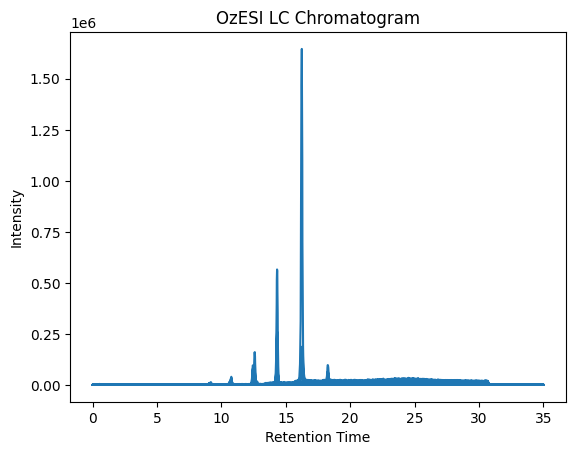

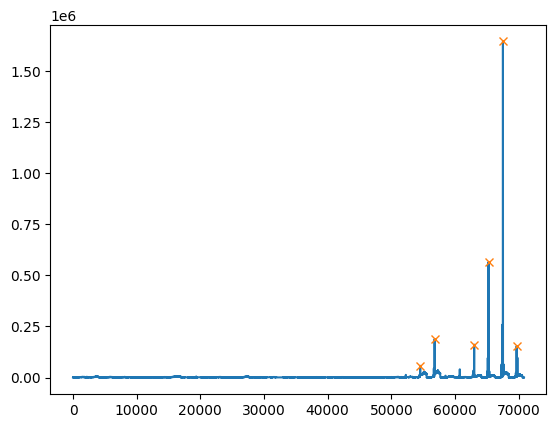

In [6]:


#length of OzESI_time
print(len(OzESI_time))
#example of structure 
print(list(OzESI_time.items())[:3])
OzESI_rt_df = pd.DataFrame(list(OzESI_time.items()), columns=['Retention_Time', 'intensity'])
#split intensity column into three columns intensity, Parent_Ion and Product_Ion
OzESI_rt_df[['intensity','Parent_Ion','Product_Ion']] = pd.DataFrame(OzESI_rt_df['intensity'].tolist(), index=OzESI_rt_df.index)
#round retention Retention_Time to 1 decimal place
OzESI_rt_df['Retention_Time'] = round(OzESI_rt_df['Retention_Time'],2)
print('Dataframe 5 largest: \n', OzESI_rt_df.nlargest(5, 'intensity'))
#Create a column called Transition with the Parent_Ion and Product_Ion
OzESI_rt_df['Transition'] = OzESI_rt_df['Parent_Ion'].astype(str) + ' -> ' + OzESI_rt_df['Product_Ion'].astype(str)

#print 5 largest values in intensity column and their Parent_Ion and Product_Ion
OzESI_rt_df_sorted = OzESI_rt_df.sort_values(['intensity'], ascending=False).drop_duplicates(['Parent_Ion','Product_Ion']).sort_index()
print('Sorted dataframe dropped duplicates 5 largest:\n',OzESI_rt_df_sorted.nlargest(10, 'intensity'))
OzESI_rt_df_top = OzESI_rt_df_sorted.nlargest(10, 'intensity')



#find peaks from OzESI_rt_df dataframe
peaks, _ = find_peaks(OzESI_rt_df['intensity'], height=0.5e5,distance=1000)
print(peaks)
plt.plot(OzESI_rt_df['Retention_Time'] ,OzESI_rt_df['intensity'])
plt.ylabel('Intensity')
plt.xlabel('Retention Time')
plt.title('OzESI LC Chromatogram')
plt.show()
plt.plot(OzESI_rt_df['intensity'])
plt.plot(peaks, OzESI_rt_df['intensity'][peaks], "x")
plt.show()

In [7]:
df.shape

(35, 7)

In [8]:
# df.tail(5) #Print the pandas dataframe
#add column for Retention_Time
df['Retention_Time'] = None
df['Intensity_OzESI'] = None

# #if transition is in OzESI_rt_df_top then add the time to the df
# for i in range(len(df)):
#     for j in range(len(OzESI_rt_df_top)):
#         if df.loc[i,'Transition'] == OzESI_rt_df_top.loc[j,'Transition']:
#             df.loc[i,'Retention_Time'] = OzESI_rt_df_top.loc[j,'time']
#             #print(df.loc[i,'Retention_Time'])

# Create a dictionary to map transitions to retention times
transitions_to_rt = dict(zip(OzESI_rt_df_top['Transition'], OzESI_rt_df_top['Retention_Time']))


# Use the map function to add retention times to the dataframe
df['Retention_Time'] = df['Transition'].map(transitions_to_rt)
transitions_to_rt = dict(zip(OzESI_rt_df_top['Transition'], OzESI_rt_df_top['intensity']))
df['Intensity_OzESI'] = df['Transition'].map(transitions_to_rt)

    
print(OzESI_rt_df_top)
df.head(None)

       Retention_Time  intensity  Parent_Ion  Product_Ion      Transition
67529           16.24  1646316.0       902.0        603.0  902.0 -> 603.0
65264           14.32   565836.0       900.0        601.0  900.0 -> 601.0
56797           16.29   188293.0       876.0        577.0  876.0 -> 577.0
63011           12.59   160993.0       898.0        599.0  898.0 -> 599.0
69675           16.23   153436.0       904.0        605.0  904.0 -> 605.0
54532           14.37    57446.0       874.0        575.0  874.0 -> 575.0
60752           10.77    40080.0       896.0        597.0  896.0 -> 597.0
52276           12.59    12987.0       872.0        573.0  872.0 -> 573.0
58507            9.17     8938.0       894.0        595.0  894.0 -> 595.0
16606           25.84     5236.0       788.0        599.0  788.0 -> 599.0


,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI
0,NaN,760.0,571.0,3508930.0,760.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
1,NaN,762.0,573.0,4454522.0,762.0 -> 573.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
2,NaN,764.0,575.0,3342623.0,764.0 -> 575.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
3,NaN,766.0,577.0,3270586.0,766.0 -> 577.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
4,NaN,782.0,593.0,2358947.0,782.0 -> 593.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
5,NaN,784.0,595.0,2304902.0,784.0 -> 595.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
6,NaN,786.0,569.0,1702709.0,786.0 -> 569.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
7,NaN,786.0,597.0,3260273.0,786.0 -> 597.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
8,NaN,788.0,571.0,1629241.0,788.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN
9,NaN,788.0,599.0,6129489.0,788.0 -> 599.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0


In [9]:

df_OzESI = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

for i in range(3,21):
    df_OzESI.loc[i,'DB_Position'] = i
    df_OzESI.loc[i,'Aldehyde_Ion'] = 26 + (14 * (i-3))

df_OzESI.head(25)


,DB_Position,Aldehyde_Ion
3,3,26
4,4,40
5,5,54
6,6,68
7,7,82
8,8,96
9,9,110
10,10,124
11,11,138
12,12,152


In [10]:
print(df.shape)
OzESI_list = [3,5,7,9,11]
starting_column = 9
last_column = 14
#create columns in found list called n-# based on the numbers in OzESI_list
for i in OzESI_list:
    df['n-' + str(i)] = ''
# print(df.head(5))
print(df.shape)
# Parent_Ion - Aldehyde_Ion *

# Subtract the aldehyde ion from the parent ion with the corresponding DB position and add the result to the found_list dataframe
for i in range(3,len(df_OzESI)):
    for j in range(len(df)):
        #if df_OzESI.loc[i,'DB_Position']:
        for k in range(starting_column,last_column):
            if df_OzESI.loc[i,'DB_Position'] == OzESI_list[k-starting_column]:
                df.iloc[j,k] = df.iloc[j,1] - df_OzESI.loc[i,'Aldehyde_Ion']

# for i, row in df_OzESI.iloc[3:].iterrows():
#     mask = df_OzESI['DB_Position'] == row['DB_Position']
#     found_list.loc[mask, OzESI_list] = found_list.loc[mask, ['Parent_Ion']].sub(row['Aldehyde_Ion'] - 1)

        
df.head(25)

(35, 9)
(35, 14)


,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-3,n-5,n-7,n-9,n-11
0,NaN,760.0,571.0,3508930.0,760.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,734.0,706.0,678.0,650.0,622.0
1,NaN,762.0,573.0,4454522.0,762.0 -> 573.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,736.0,708.0,680.0,652.0,624.0
2,NaN,764.0,575.0,3342623.0,764.0 -> 575.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,738.0,710.0,682.0,654.0,626.0
3,NaN,766.0,577.0,3270586.0,766.0 -> 577.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,740.0,712.0,684.0,656.0,628.0
4,NaN,782.0,593.0,2358947.0,782.0 -> 593.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,756.0,728.0,700.0,672.0,644.0
5,NaN,784.0,595.0,2304902.0,784.0 -> 595.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,758.0,730.0,702.0,674.0,646.0
6,NaN,786.0,569.0,1702709.0,786.0 -> 569.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
7,NaN,786.0,597.0,3260273.0,786.0 -> 597.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
8,NaN,788.0,571.0,1629241.0,788.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,762.0,734.0,706.0,678.0,650.0
9,NaN,788.0,599.0,6129489.0,788.0 -> 599.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0,762.0,734.0,706.0,678.0,650.0


Load MRM transitions from csv file to pandas dataframe. This list will be used to identify the possible lipids in our sample.

In [12]:
# create a dictionary to store the matching parent/product ion pairs and their corresponding lipids and classes
ion_dict = {}
for index, row in mrm_database.iterrows():
    ion_dict[(row['Parent_Ion'], row['Product_Ion'])] = (row['Lipid'], row['Class'])

# create empty columns for Lipid and Class
df['Lipid'] = np.nan
df['Class'] = np.nan

# loop through the rows in df and check if the corresponding parent/product ion pair exists in ion_dict
for index, row in df.iterrows():
    if (row['Parent_Ion'], row['Product_Ion']) in ion_dict:
        df.at[index, 'Lipid'] = ion_dict[(row['Parent_Ion'], row['Product_Ion'])][0]
        df.at[index, 'Class'] = ion_dict[(row['Parent_Ion'], row['Product_Ion'])][1]

# # drop rows with NaN values
# df_matching = df.dropna(subset=['Lipid'])
# df_matching = df_matching.reset_index(drop=True)
df.head(25)

,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-3,n-5,n-7,n-9,n-11
0,PG(34:4),760.0,571.0,3508930.0,760.0 -> 571.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,734.0,706.0,678.0,650.0,622.0
1,"PG(34:3),PG(P-35:2)",762.0,573.0,4454522.0,762.0 -> 573.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,736.0,708.0,680.0,652.0,624.0
2,"PG(O-35:2),PG(P-35:1)",764.0,575.0,3342623.0,764.0 -> 575.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,738.0,710.0,682.0,654.0,626.0
3,"PG(O-35:1),PG(P-35:0)",766.0,577.0,3270586.0,766.0 -> 577.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,740.0,712.0,684.0,656.0,628.0
4,"PG(36:7),PG(35:0),PG(O-36:0)",782.0,593.0,2358947.0,782.0 -> 593.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,756.0,728.0,700.0,672.0,644.0
5,PG(36:6),784.0,595.0,2304902.0,784.0 -> 595.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,758.0,730.0,702.0,674.0,646.0
6,NaN,786.0,569.0,1702709.0,786.0 -> 569.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
7,PG(36:5),786.0,597.0,3260273.0,786.0 -> 597.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
8,NaN,788.0,571.0,1629241.0,788.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,762.0,734.0,706.0,678.0,650.0
9,PG(36:4),788.0,599.0,6129489.0,788.0 -> 599.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0,762.0,734.0,706.0,678.0,650.0


In [13]:
df_test = df.copy()
df_test['Parent_Ion'] = df_test['Parent_Ion'].astype(float)
#Convert all n-# columns to float
for i in OzESI_list:
    df_test['n-' + str(i)] = df_test['n-' + str(i)].astype(float)

# print(df_test[['Parent_Ion','n-3']].dtypes)
print(df['Parent_Ion'].dtypes)
print(df['n-3'].dtypes)

# def replace_lipid(row):
#     if pd.isna(row['Lipid']):
#         parent_ion = row['Parent_Ion']
#         if parent_ion == row['n-3']:
#             row['Lipid'] = 'n-3'
#         elif parent_ion == row['n-5']:
#             return 'n-5'
#         elif parent_ion == row['n-7']:
#             return 'n-7'
#         elif parent_ion == row['n-9']:
#             return 'n-9'
#         elif parent_ion == row['n-11']:
#             return 'n-11'
#         else:
#             return np.nan
#     else:
#         return row['Lipid']


#search for n-# in Parent_Ion and add the corresponding lipid to the Lipid column
for i in range(len(df_test)):
    for j in range(len(df_test)):
        if pd.isna(df_test.loc[i,'Lipid']):
            parent_ion = df_test.loc[i,'Parent_Ion']
            if parent_ion == df_test.loc[j,'n-3'] and isinstance(df_test.loc[j,'Lipid'], str):
                df_test.loc[i,'Lipid'] = 'n-3 ' + (df_test.loc[j,'Lipid'])

            elif parent_ion == df_test.loc[j,'n-5'] and isinstance(df_test.loc[j,'Lipid'], str):
                df_test.loc[i,'Lipid'] = 'n-5 ' + (df_test.loc[j,'Lipid'])
            elif parent_ion == df_test.loc[j,'n-7'] and isinstance(df_test.loc[j,'Lipid'], str):
                df_test.loc[i,'Lipid'] = 'n-7 ' + (df_test.loc[j,'Lipid'])
            elif parent_ion == df_test.loc[j,'n-9'] and isinstance(df_test.loc[j,'Lipid'], str):
                df_test.loc[i,'Lipid'] = 'n-9 ' + (df_test.loc[j,'Lipid'])
            elif parent_ion == df_test.loc[j,'n-11'] and isinstance(df_test.loc[j,'Lipid'], str):
                df_test.loc[i,'Lipid'] = 'n-11 '+ (df_test.loc[j,'Lipid'])
            else:
                pass
                # df_test.loc[i,'Lipid'] = np.nan
# Apply the function to each row of the dataframe





# df_test['Lipid'] = df_test.apply(replace_lipid,axis=1)
# Print the updated dataframe
df_test.head(None)

object
object


,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-3,n-5,n-7,n-9,n-11
0,PG(34:4),760.0,571.0,3508930.0,760.0 -> 571.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,734.0,706.0,678.0,650.0,622.0
1,"PG(34:3),PG(P-35:2)",762.0,573.0,4454522.0,762.0 -> 573.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,736.0,708.0,680.0,652.0,624.0
2,"PG(O-35:2),PG(P-35:1)",764.0,575.0,3342623.0,764.0 -> 575.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,738.0,710.0,682.0,654.0,626.0
3,"PG(O-35:1),PG(P-35:0)",766.0,577.0,3270586.0,766.0 -> 577.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,740.0,712.0,684.0,656.0,628.0
4,"PG(36:7),PG(35:0),PG(O-36:0)",782.0,593.0,2358947.0,782.0 -> 593.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,756.0,728.0,700.0,672.0,644.0
5,PG(36:6),784.0,595.0,2304902.0,784.0 -> 595.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,758.0,730.0,702.0,674.0,646.0
6,n-7 [TG(52:6)]_FA18:1,786.0,569.0,1702709.0,786.0 -> 569.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
7,PG(36:5),786.0,597.0,3260273.0,786.0 -> 597.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
8,n-7 [TG(52:5)]_FA18:1,788.0,571.0,1629241.0,788.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,762.0,734.0,706.0,678.0,650.0
9,PG(36:4),788.0,599.0,6129489.0,788.0 -> 599.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0,762.0,734.0,706.0,678.0,650.0


In [190]:
df.head(None)

,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-3,n-5,n-7,n-9,n-11
0,PG(34:4),760.0,571.0,3508930.0,760.0 -> 571.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,734.0,706.0,678.0,650.0,622.0
1,"PG(34:3),PG(P-35:2)",762.0,573.0,4454522.0,762.0 -> 573.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,736.0,708.0,680.0,652.0,624.0
2,"PG(O-35:2),PG(P-35:1)",764.0,575.0,3342623.0,764.0 -> 575.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,738.0,710.0,682.0,654.0,626.0
3,"PG(O-35:1),PG(P-35:0)",766.0,577.0,3270586.0,766.0 -> 577.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,740.0,712.0,684.0,656.0,628.0
4,"PG(36:7),PG(35:0),PG(O-36:0)",782.0,593.0,2358947.0,782.0 -> 593.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,756.0,728.0,700.0,672.0,644.0
5,PG(36:6),784.0,595.0,2304902.0,784.0 -> 595.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,758.0,730.0,702.0,674.0,646.0
6,n-7 [TG(52:6)]_FA18:1,786.0,569.0,1702709.0,786.0 -> 569.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
7,PG(36:5),786.0,597.0,3260273.0,786.0 -> 597.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
8,n-7 [TG(52:5)]_FA18:1,788.0,571.0,1629241.0,788.0 -> 571.0,NaN,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,762.0,734.0,706.0,678.0,650.0
9,PG(36:4),788.0,599.0,6129489.0,788.0 -> 599.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0,762.0,734.0,706.0,678.0,650.0


In [76]:
df_matching.head(None)

,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-3,n-5,n-7,n-9,n-11
0,PG(34:4),760.0,571.0,3508930.0,760.0 -> 571.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,734.0,706.0,678.0,650.0,622.0
1,"PG(34:3),PG(P-35:2)",762.0,573.0,4454522.0,762.0 -> 573.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,736.0,708.0,680.0,652.0,624.0
2,"PG(O-35:2),PG(P-35:1)",764.0,575.0,3342623.0,764.0 -> 575.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,738.0,710.0,682.0,654.0,626.0
3,"PG(O-35:1),PG(P-35:0)",766.0,577.0,3270586.0,766.0 -> 577.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,740.0,712.0,684.0,656.0,628.0
4,"PG(36:7),PG(35:0),PG(O-36:0)",782.0,593.0,2358947.0,782.0 -> 593.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,756.0,728.0,700.0,672.0,644.0
5,PG(36:6),784.0,595.0,2304902.0,784.0 -> 595.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,758.0,730.0,702.0,674.0,646.0
6,PG(36:5),786.0,597.0,3260273.0,786.0 -> 597.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,760.0,732.0,704.0,676.0,648.0
7,PG(36:4),788.0,599.0,6129489.0,788.0 -> 599.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,25.84,5236.0,762.0,734.0,706.0,678.0,650.0
8,"PG(36:3),PG(P-37:2)",790.0,601.0,2584182.0,790.0 -> 601.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,764.0,736.0,708.0,680.0,652.0
9,"PG(O-37:2),PG(P-37:1)",792.0,603.0,3311812.0,792.0 -> 603.0,PG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,NaN,NaN,766.0,738.0,710.0,682.0,654.0


In [126]:
#for loop to check if that file already exists and if it does then add a number to the end of the file name so data is not overwritten
name_of_folder = 'canola'
name_of_file = 'canola'


for i in range(5):
    if not os.path.isfile('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i)):
        df_matching.to_excel('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i), index=False)
        break
    elif not os.path.isfile('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i)):
        df_matching.to_excel('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i), index=False)
        break
    else:
        pass
df_matching.tail(5)

,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI
28,"[TG(53:9),TG(52:2)]_FA18:1",876.0,577.0,26769009.0,876.0 -> 577.0,TAG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,16.29,188293.0
31,[TG(54:5)]_FA18:1,898.0,599.0,12535827.0,898.0 -> 599.0,TAG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,12.59,160993.0
32,"[TG(55:11),TG(54:4)]_FA18:1",900.0,601.0,14229465.0,900.0 -> 601.0,TAG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,14.32,565836.0
33,"[TG(55:10),TG(54:3)]_FA18:1",902.0,603.0,34867382.0,902.0 -> 603.0,TAG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,16.24,1646316.0
34,"[TG(55:9),TG(54:2)]_FA18:1",904.0,605.0,12858486.0,904.0 -> 605.0,TAG,TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...,16.23,153436.0


In [128]:
#plot transition versus intensity of df_matching
fig = px.bar(df_matching, x="Transition", y="Intensity", color="Lipid", hover_data=['Lipid','Class'])
fig.update_layout(
      title_text="MRM Intensity")
fig.show()

#plot transition versus intensity of df_matching
fig = px.bar(df_matching, x="Transition", y="Intensity_OzESI", color="Lipid", hover_data=['Lipid','Class'])
fig.update_layout(
      title_text="LC OzESI Intensity")

fig.show()



# #plot lipid class versus intensity of df_matching in a bar chart
# fig = px.bar(df_matching, x="Class", y="Intensity", color="Class", hover_data=['Lipid','Class'])
# fig.show()
# #plot lipid class versus intensity of df_matching in a pie chart
# fig = px.pie(df_matching, values='Intensity', names='Class', title='Lipid Class')
# fig.show()
#make a plotly heatmap of the intensity of each transition in each sample
fig = go.Figure(data=go.Heatmap(
                     z=df_matching['Intensity'],
                        x=df_matching['Lipid'],
                        y=df_matching['Class'],
                        colorscale='Viridis'))
fig.show()

# #plot sample ID versus intensity of df_matching
# fig = px.bar(df_matching, x="Sample_ID", y="Intensity", color="Sample_ID", hover_data=['Lipid','Class'])
# fig.show()
# #plot sample ID versus intensity of df_matching in a pie chart
# fig = px.pie(df_matching, values='Intensity', names='Sample_ID', title='Sample ID')
# fig.show()